In [11]:
# 1. Install necessary libraries
!pip install open3d numpy tensorflow matplotlib

In [12]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 2. Load point cloud data

import open3d as o3d
import numpy as np

def load_point_cloud(file_path):
    """
    Load the point cloud from a .ply file.
    """
    point_cloud = o3d.io.read_point_cloud(file_path)
    points = np.asarray(point_cloud.points)  # Extract point coordinates
    return points

def normalize_points(points):
    """
    Normalize the point cloud coordinates to a fixed scale.
    """
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)
    return normalized_points

# Load and normalize the point cloud
point_cloud_file = "/content/drive/MyDrive/training_point_cloud.ply"
points = load_point_cloud(point_cloud_file)
normalized_points = normalize_points(points)
print(f"Loaded point cloud with {points.shape[0]} points.")

Loaded point cloud with 12400 points.


In [14]:
# 3. Preprocess point cloud data
def preprocess_points(points, num_features=3, pillar_size=3):
    """
    Preprocess points to match the model's expected input shape.
    """
    num_points = points.shape[0]
    reshaped_points = points[:num_points - (num_points % pillar_size)].reshape((-1, num_features, pillar_size))
    return reshaped_points

reshaped_points = preprocess_points(normalized_points)
print(f"Reshaped points shape: {reshaped_points.shape}")

Reshaped points shape: (4133, 3, 3)


In [15]:
# 4. Load and preprocess labels
def load_labels(file_path):
    """
    Load labels from a text file, skipping any header lines.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    labels = np.array([int(line.strip()) for line in lines if not line.startswith("#")])
    return labels

    # Trim and reshape labels to match points
def preprocess_labels(labels, num_points, pillar_size):
    """
    Reshape labels to match the reshaped point cloud.
    This assumes that each pillar corresponds to a single label.
    """
    labels = labels[:num_points - (num_points % pillar_size)]
    reshaped_labels = labels.reshape((-1, pillar_size))
    # Use the mode (most common label) for each pillar
    pillar_labels = np.array([np.bincount(pillar).argmax() for pillar in reshaped_labels])
    return pillar_labels

# Load the labels
labels_file_path = "/content/drive/MyDrive/training_labels.txt"
labels = load_labels(labels_file_path)
reshaped_labels = preprocess_labels(labels, points.shape[0], 3)
print(f"Reshaped labels shape: {reshaped_labels.shape}")

# Ensure `num_classes` is set correctly
num_classes = max(reshaped_labels) + 1
print(f"Number of classes: {num_classes}")

Reshaped labels shape: (4133,)
Number of classes: 7


In [16]:
# 5. Build PointPillars model
import tensorflow as tf

def build_pointpillars_model(input_shape=(3, 3)):
    """
    Build a simple PointPillars-like model using dense layers.
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="PointPillars")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

input_shape = reshaped_points.shape[1:]
pointpillars_model = build_pointpillars_model(input_shape)
pointpillars_model.summary()

# Convert labels to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(reshaped_labels, num_classes=num_classes)
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")

Model: "PointPillars"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,847 (46.28 KB)

 Trainable params: 11,847 (46.28 KB)

 Non-trainable params: 0 (0.00 B)

One-hot encoded labels shape: (4133, 7)


In [17]:
# 6. Train the model
history = pointpillars_model.fit(
    reshaped_points,
    one_hot_labels,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6546 - loss: 1.3952 - val_accuracy: 0.0326 - val_loss: 8.7602
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9471 - loss: 0.1372 - val_accuracy: 0.0326 - val_loss: 12.1602
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9831 - loss: 0.0552 - val_accuracy: 0.0326 - val_loss: 14.0421
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9819 - loss: 0.0526 - val_accuracy: 0.0326 - val_loss: 15.0622
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9834 - loss: 0.0396 - val_accuracy: 0.0326 - val_loss: 15.3297
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9880 - loss: 0.0330 - val_accuracy: 0.0326 - val_loss: 15.7550
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9838 - loss: 0.0409 - val_accuracy: 0.0326 - val_loss: 16.1448
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0365 - v

In [18]:
# 7. Visualize results with detected object summary
def summarize_detected_objects(points, predictions):
    """
    Summarize detected objects and their counts.
    """
    predicted_classes = np.argmax(predictions, axis=1)
    object_points = points[predicted_classes == 1]  # Example: assume class 1 is "object"
    non_object_points = points[predicted_classes == 0]  # Class 0 as non-object

    # Print summary
    print(f"Total Points: {points.shape[0]}")
    print(f"Points identified as objects: {object_points.shape[0]}")
    print(f"Points identified as non-objects: {non_object_points.shape[0]}")

    # If further labels exist, categorize detected objects (example)
    object_classes = {1: "Tree", 2: "Building", 3: "Car", 4: "Person"}  # Example mapping
    unique, counts = np.unique(predicted_classes, return_counts=True)
    print("\nDetected Object Summary:")
    for cls, count in zip(unique, counts):
        obj_name = object_classes.get(cls, f"Unknown (Class {cls})")
        print(f"  - {obj_name}: {count} points")

# Predict object classes for the reshaped points
predictions = pointpillars_model.predict(reshaped_points)

# Summarize detected objects
summarize_detected_objects(normalized_points[:reshaped_points.shape[0]], predictions)


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total Points: 4133
Points identified as objects: 587
Points identified as non-objects: 0

Detected Object Summary:
  - Tree: 587 points
  - Building: 710 points
  - Car: 1667 points
  - Person: 1169 points


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


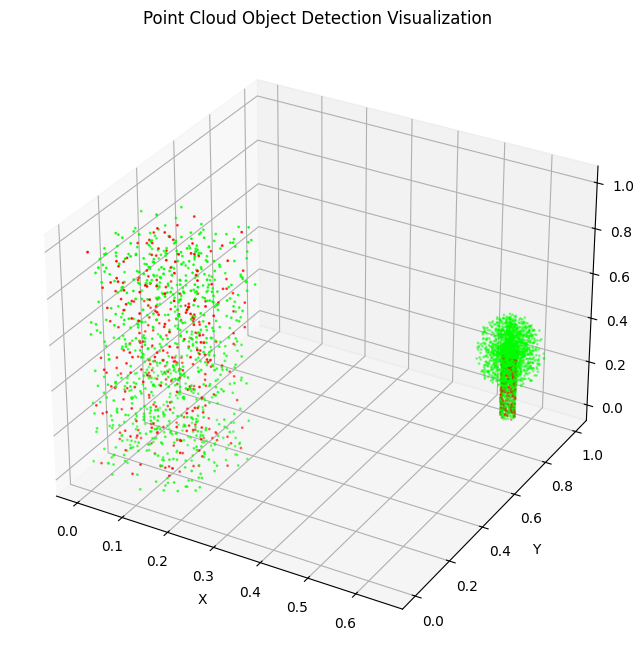

In [19]:
# 8. Visualize results with Matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_detected_objects_matplotlib(points, predictions):
    """
    Visualize the point cloud with detected labels using Matplotlib.
    """
    predicted_classes = np.argmax(predictions, axis=1)
    colors = np.array([[1, 0, 0] if cls == 1 else [0, 1, 0] for cls in predicted_classes])  # Red for class 1, Green for class 0

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)

    ax.set_title("Point Cloud Object Detection Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Predict object classes for the reshaped points
predictions = pointpillars_model.predict(reshaped_points)

# Visualize predictions using Matplotlib
visualize_detected_objects_matplotlib(normalized_points[:reshaped_points.shape[0]], predictions)

In [22]:
# Save PointPillars model
save_path = "/content/drive/MyDrive/PointPillars_Object_Detection.h5"
pointpillars_model.save(save_path)
print(f"PointPillars model saved to {save_path}")

PointPillars model saved to /content/drive/MyDrive/PointPillars_Object_Detection.h5
